# Simulating the radial age distribution of classical cepheids
### using BaSTI stellar models

In [1]:
# MIT License
# 2022-25 C. Padois, F. Anders, M. Vilanova (ICCUB)

In [2]:
import os.path
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
import matplotlib
import matplotlib.ticker as ticker

import math 
import scipy as sc
import matplotlib.cm as cm
#from matplotlib import rc
#rc('font',**{'family':'serif','serif':['Times']})
#rc('text', usetex=False)
#rc('font',**{'size':20})
import seaborn as sns
from astropy.table import Table
from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style)
import astropy.units as u
import pandas as pd
from scipy.stats import gaussian_kde

import cepheid_utils, open_basti

from tqdm import tqdm

For faster plots comment out the next cell:

In [3]:
import scipy as sc
import matplotlib.cm as cm
from matplotlib import rc
rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('font',**{'size':20})

## Trying a simple simulation of the Cepheid population using PARSEC models

We need the following ingredients:

* constant SFR - exponential in Rgal
* constant IMF
* approximate mass-age relation for Cepheids
* radial metallicity gradient

* possibly a metallicity-dependent instability strip

In [4]:
def sfr(Rscale=3.5, A=10000.):
    # Draw random samples from an exponential distribution
    return np.random.exponential(scale=Rscale, size=A)

def imf(a=2.35, mmin=3, mmax=15, samples=100):
    # Draw random samples from a Salpeter IMF
    return mmax-(mmax-mmin)*np.random.power(a, samples)

def mass_to_ms_lifetime(mass):
    # Convert masses into lifetimes - 
    # +-valid for stars close to their death (from the PARSEC models)
    # 9.9 - 3.4 * log10(x) + 0.75* pow(log10(x),2)
    return 10.**(3.9 - 3.4 * np.log10(mass) + 0.75 * np.log10(mass)**2.) # in Myr

def mass_to_lifetime(mass):
    # Convert masses into lifetimes - 
    # +-valid for stars close to their death 
    # 10.2 - 3.75 * log10(x) + 1.* pow(log10(x),2)
    return 10.**(4.2 - 3.75 * np.log10(mass) + 1. * np.log10(mass)**2.) # in Myr

def simulate_stars(tmax=500, timesteps=10000, Nbirth=1000, feh_gradient="genovali2014"):
    """
    Sample stars from a simple recipe, assigning age, radius, mass, lifetime, metallicity
    
    (optional )Args:
        tmax      - maximum time to simulate (default: 500 Myr)
        timesteps - number of timesteps in between (default:1000)
        Nbirth    - how many stars are created in each timestep (default: 1000)
        feh_gradient - default: "genovali2014"
    
    Returns:
        stars - numpy recarray with columns ["age", "R", "M", "[Fe/H]", "Z", "lifetime"]
    """
    for ti in tqdm(np.linspace(0, tmax, timesteps)):
        # let's sample some stars per timestep from the birthrate function:
        newstars = np.array([ np.zeros(Nbirth) ], 
                      dtype=[('R', '<f8'), ('M', '<f8'), ('age', '<f8'), 
                             ('[Fe/H]', '<f8'), ('Z', '<f8'), ('lifetime', '<f8')])
        # birth time:
        newstars["age"] = tmax - ti * np.ones(Nbirth)
        # birth radius:
        newstars["R"] = sfr(A=Nbirth)
        # birth mass
        newstars["M"] = imf(samples=Nbirth)
        # Give an approximate lifetime
        newstars["lifetime"]=mass_to_lifetime(newstars["M"])
        if feh_gradient=="genovali2014":
            # Give a metallicity following the [Fe/H] gradient measured by Genovali+2014
            newstars["[Fe/H]"]  = 0.57 - 0.06 * newstars["R"] + np.random.normal(scale=0.05, size=Nbirth)
        elif feh_gradient=="none":
            newstars["[Fe/H]"]  = 0.0 + np.random.normal(scale=0.05, size=Nbirth)
        else:
            raise ValueError("Not a valid option for feh_gradient")
            
        newstars["Z"]       = 10.**(newstars["[Fe/H]"] - 1.77)
        # Append this to stars array
        if ti == 0:
            stars = newstars
        else:
            stars = np.hstack([stars, newstars])
        #if ti % 100 == 0:
        #    print(ti)
    return stars


## Read stellar models

In [5]:
basti = pd.read_parquet("./isochrones/basti_models_standard.parquet")
# basti=open_basti.open_basti(basti_dir="./isochrones/BaSTI/") # slower
basti

,logage,m_ini,logl,logteff,G,G_BP,G_RP,m_h
0,-9.000000,3.1,2.38428,3.66884,-1.0962,-0.5626,-1.7772,-0.2
1,3.717361,3.1,2.33033,3.67299,-0.9763,-0.4547,-1.6477,-0.2
2,4.018391,3.1,2.22668,3.68080,-0.7419,-0.2419,-1.3957,-0.2
3,4.194482,3.1,2.15336,3.68542,-0.5713,-0.0833,-1.2148,-0.2
4,4.319421,3.1,2.10457,3.68849,-0.4575,0.0225,-1.0941,-0.2
...,...,...,...,...,...,...,...,...
2267995,7.187575,14.0,4.74067,3.60673,-6.6843,-5.9209,-7.5279,-0.6
2267996,7.187585,14.0,4.75011,3.60585,-6.7027,-5.9356,-7.5487,-0.6
2267997,7.187594,14.0,4.75546,3.60536,-6.7131,-5.9439,-7.5604,-0.6
2267998,7.187604,14.0,4.76457,3.60458,-6.7310,-5.9583,-7.5805,-0.6


## Simulate fake stars & Match them to the stellar models
<span style="color:red"> You can skip this part if using precomputed matching. </span>

assoc_models = cut_out_cepheids(stars, basti, savefile="./simulations/sim_gradient_basti_assoc_models_CP_2maig.fits")
assoc_models_sinRgrad = cut_out_cepheids(stars_noRgrad, basti, savefile="./simulations/sim_gradient_basti_assoc_models_CP_14maig_noRgrad.fits")

## <span style="color:red"> >> Continue here if you don't want to redo the matching << </span>

In [6]:
# Fiducial simulation: exponential disc, IMF, radial [Fe/H] gradient
assoc_models          = Table.read("./simulations/sim_gradient_basti_assoc_models_CP_2maig.fits")
# Simulation without [Fe/H] gradient
assoc_models_sinRgrad = Table.read("./simulations/sim_gradient_basti_assoc_models_CP_14maig_noRgrad.fits")

In [7]:
assoc_models

logage,m_ini,logl,logteff,G,G_BP,G_RP,m_h,R,age_sim
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8.60407796,3.0,3.29312,3.60765,-3.0741,-2.3303,-3.9069,-0.2,12.65474861008833,434.3934393439344
8.63744526396,3.0,1.91752,3.70861,-0.0494,0.3942,-0.6512,0.15,5.8109309382953125,433.84338433843385
8.63726301978,3.0,1.98595,3.71103,-0.2238,0.2105,-0.8178,0.06,8.332106380106223,433.74337433743375
8.63713363547,3.0,1.91702,3.70862,-0.0481,0.3954,-0.6499,0.15,6.514561548874051,433.74337433743375
8.63342965,3.0,3.16797,3.61021,-2.7732,-2.0328,-3.6035,-0.1,12.119368989639483,433.5933593359336
8.63619740612,3.0,1.91572,3.70867,-0.045,0.3984,-0.6467,0.15,8.181518723670237,432.64326432643264
...,...,...,...,...,...,...,...,...,...
6.99771633992,13.9,4.39686,4.42431,-3.6864,-3.8347,-3.4029,0.06,9.277343700328426,9.950995099509953
6.99575551704,14.1,4.41903,4.42551,-3.7367,-3.8854,-3.4527,0.06,8.586564950609922,9.900990099009903


## IS as Mor+2017

Now cut out the Cepheids in the same way as in Mor+2017: We define the instability strip

In [8]:
blue_edge = ( assoc_models["logteff"]  < -( assoc_models["logl"] - 62.7)/15.8 ) # Bono+2009
blue_edge2= ( assoc_models["logteff"]  < -( assoc_models["logl"] - 52.5)/13.1 ) # Fiorentino+2013
red_edge  = ( assoc_models["logteff"]  > -( assoc_models["logl"] - 40.2)/10.0 ) # Fiorentino+2013
lumi_cut  = ( assoc_models["logteff"] > 2.7 ) * ( assoc_models["logl"] < 4.7 )   # Bono+1999

cephcut   = blue_edge2 * red_edge * lumi_cut 

### >>> constant IS

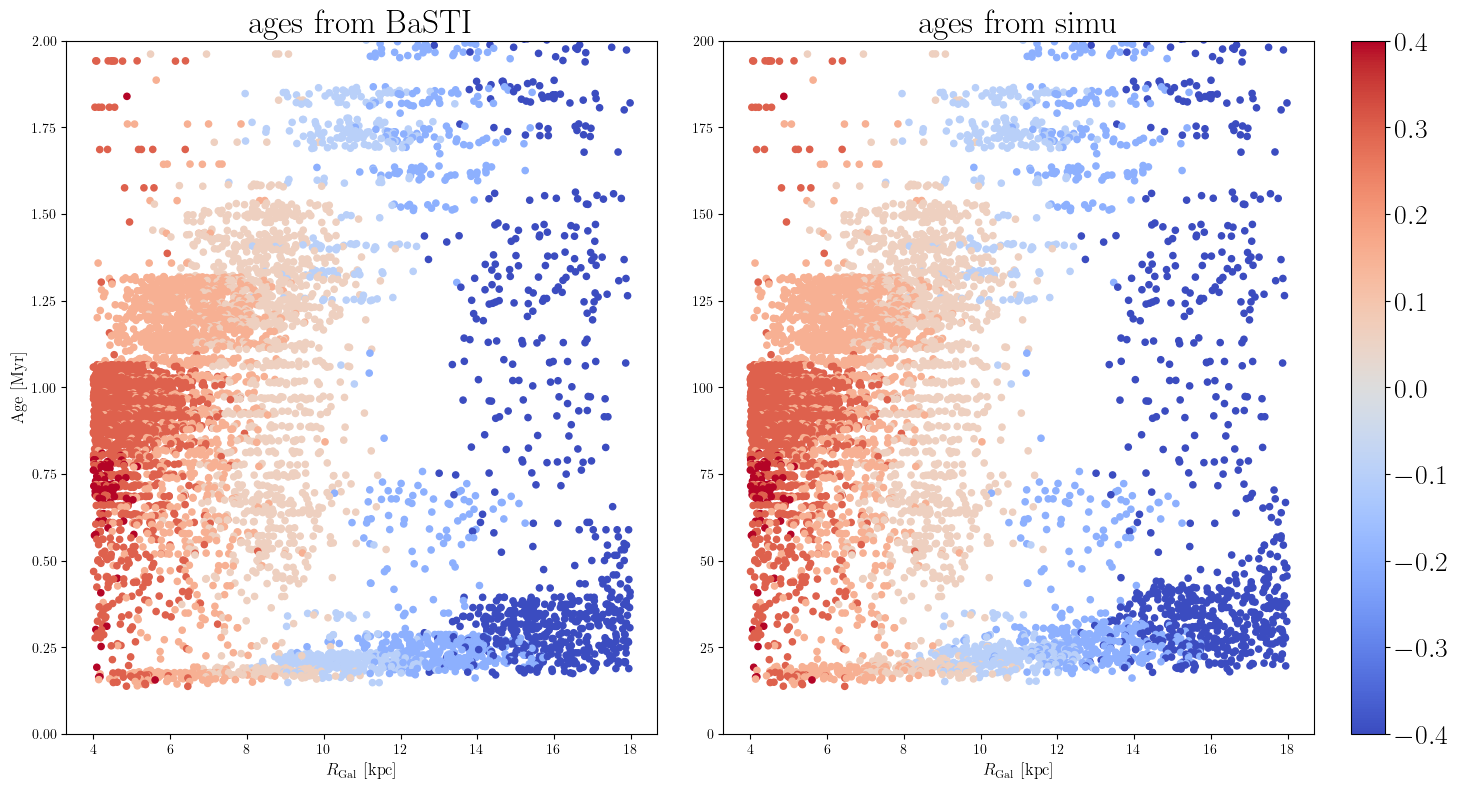

In [9]:
assoc_models['Z']=10**(-1.77+assoc_models["m_h"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18.0, 9.0), sharex=True, 
                               gridspec_kw={'width_ratios': [0.8, 1]})
fig.subplots_adjust(wspace=0.1)
ec   = None
# PLOT weightened by Z
c1 = ax1.scatter(assoc_models["R"][cephcut], (10**assoc_models["logage"][cephcut])/1e8, c=assoc_models["m_h"][cephcut],
            s=20, marker="o", edgecolor=ec, vmin=-0.4, vmax=0.4, cmap="coolwarm") 

ax2.scatter(assoc_models["R"][cephcut], assoc_models["age_sim"][cephcut], c=assoc_models["m_h"][cephcut],
            s=20, marker="o", edgecolor=ec, vmin=-0.4, vmax=0.4, cmap="coolwarm") 

# Beautify the plot
ax1.set_xlabel(r"$R_{\rm Gal}$  [kpc]", fontsize=12)
ax1.set_ylabel(r"Age    [Myr]", fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_ylim(0, 2)
ax2.set_ylim(0, 200)

ax2.set_xlabel(r"$R_{\rm Gal}$  [kpc]", fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=10)

ax1.set_title("ages from BaSTI")
ax2.set_title("ages from simu")

cbar = fig.colorbar(c1, ax=ax2)
#cbar.ax.set_ticklabels(fontsize=10)
#plt.title("R_age_metallicity_no_int", fontsize=10)
#plt.savefig("R_age_metallicity_no_int.png", dpi=200)
plt.show()

## IS as in deSomma+2021 
Metallicity dependence of the IS with the 3 bins

Cutting the Cepehids for three different metallicities

In [10]:
#Metallicity cuts centered in Z=0.004, Z=0.008 and Z=0.03 
#Change Z to m_h
assoc_models['Z']=10**(-1.77+assoc_models["m_h"])

Zcut1=(assoc_models["Z"]<0.006)
Zcut2=(assoc_models["Z"]>=0.006) & (assoc_models["Z"]<0.019)
Zcut3=(assoc_models["Z"]>0.019)
print(min(assoc_models["Z"]))

0.004265795188015926


Here we can define two cases for the definition of the IS (as they do in Somma+2021):

    -Case A: Canonical luminosity level (neglecting core overshooting, rotation and mass loss)
    -Case B: Non-canonical luminosity level, obtained by increasing the canonical luminosity level by log(L/Lo)=2.5

In [11]:
#Definition of the constants that will define the slope of the IS
case_A={}
case_A['Z=0.004']=[3.826, 0.016, 3.958, 0.074]
case_A['Z=0.03']=[3.979, 0.07, 4.009, 0.096]
case_B={}
case_B['Z=0.004']=[3.849, 0.022, 3.937, 0.069]
case_B['Z=0.03']=[3.976, 0.07, 4.048, 0.111]
#Choose the model 
model= 'A'
#Set the model
if model == 'A':
    case=case_A
else:
    case=case_B

In [12]:
# Definition of instability strips from Somma+2021 Z=(0.004,0.008,0.02)
blue_edge1= assoc_models["logteff"][Zcut1] < (case['Z=0.004'][0]+assoc_models["logl"][Zcut1]*-case['Z=0.004'][1])
blue_edge2= assoc_models["logteff"][Zcut2] < (3.833+assoc_models["logl"][Zcut2]*-0.02)
blue_edge3= assoc_models["logteff"][Zcut3] < (case['Z=0.03'][0]+assoc_models["logl"][Zcut3]*-case['Z=0.03'][1])
red_edge1= assoc_models["logteff"][Zcut1] > (case['Z=0.004'][2]+assoc_models["logl"][Zcut1]*-case['Z=0.004'][3])
red_edge2= assoc_models["logteff"][Zcut2] > (3.975+assoc_models["logl"][Zcut2]*-0.081)
red_edge3= assoc_models["logteff"][Zcut3] > (case['Z=0.03'][2]+assoc_models["logl"][Zcut3]*-case['Z=0.03'][3])
#Extra luminosity cut 
lumi_cut  = ( assoc_models["logl"] > 2.7 ) * ( assoc_models["logl"] < 4.7 )   # Bono+1999 (modified for L>2.5)
#Cuts
cephcut1=blue_edge1*red_edge1*lumi_cut[Zcut1]
cephcut2=blue_edge2*red_edge2*lumi_cut[Zcut2]
cephcut3=blue_edge3*red_edge3*lumi_cut[Zcut3]

Here we define an array which is the sum of the two metallicity types described above, i.e. the total number of stars that will fit inside their IS(Z) bin.

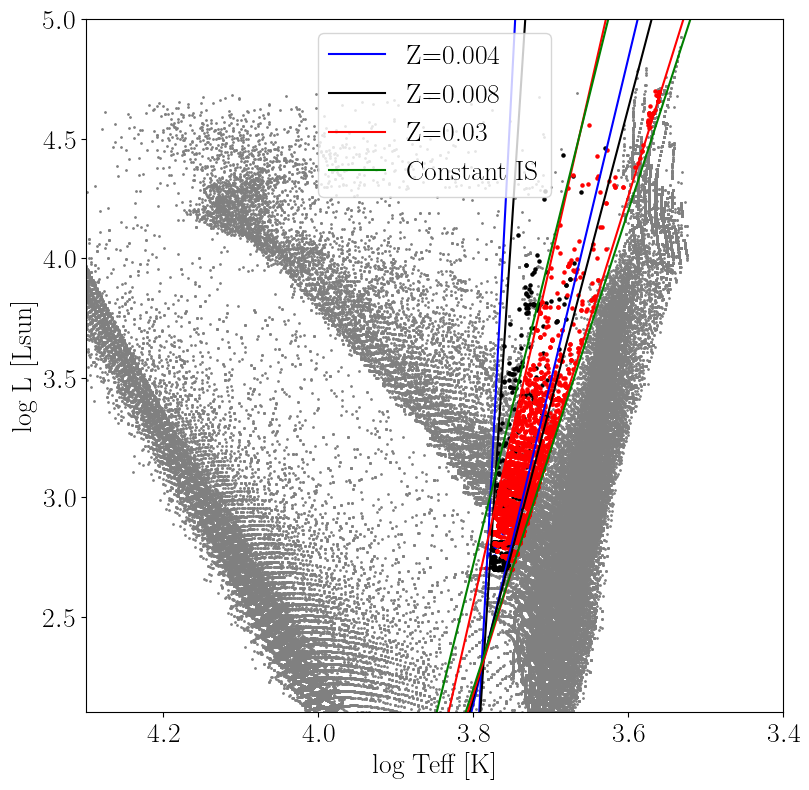

In [13]:
fig = plt.figure(figsize=(9.0, 9.0))
ax  = plt.subplot(111)
#Plot all stars (grey) and 2 metallicity types 
plt.scatter(assoc_models["logteff"], assoc_models["logl"], c="grey", s=1)
plt.scatter(assoc_models["logteff"][Zcut1][cephcut1], assoc_models["logl"][Zcut1][cephcut1], c="b", s=5)
plt.scatter(assoc_models["logteff"][Zcut2][cephcut2], assoc_models["logl"][Zcut2][cephcut2], c="black",s=5)
plt.scatter(assoc_models["logteff"][Zcut3][cephcut3], assoc_models["logl"][Zcut3][cephcut3], c="r", s=5)
x=np.arange(1,9)
#For Z=0.004 instability strips limits
plt.plot(x, (-case['Z=0.004'][0]+x)/-case['Z=0.004'][1], c="b")
plt.plot(x, (-case['Z=0.004'][2]+x)/-case['Z=0.004'][3], c="b", label='Z=0.004')
#For Z=0.008 instability strips limits (0 stars not worth it)
plt.plot(x, (-3.833+x)/-.02, c="k")
plt.plot(x, (-3.975+x)/-.081, c="k", label='Z=0.008')
#For Z=0.03 instability strips limits
plt.plot(x, (-case['Z=0.03'][0]+x)/-case['Z=0.03'][1], c="r")
plt.plot(x, (-case['Z=0.03'][2]+x)/-case['Z=0.03'][3], c="r", label='Z=0.03')
#No-metallicity gradient (Fiorentino+2013)
plt.plot(x, -(13.1*x)+52.5, c="g", label='Constant IS')
plt.plot(x, -(10.0*x)+40.2, c="g")
#Beautify the plot
plt.axis([4.3,3.4,2.1,5])
plt.legend()
ax.set_xlabel(r"log Teff [K]", fontsize=20)
ax.set_ylabel(r"log L [Lsun]", fontsize=20)
#plt.savefig('HR_Z_Somma2016.png', dpi=200)
plt.show()

Age(R_gal) for Cepheids

In [14]:
assoc_models

logage,m_ini,logl,logteff,G,G_BP,G_RP,m_h,R,age_sim,Z
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8.60407796,3.0,3.29312,3.60765,-3.0741,-2.3303,-3.9069,-0.2,12.65474861008833,434.3934393439344,0.010715193052376065
8.63744526396,3.0,1.91752,3.70861,-0.0494,0.3942,-0.6512,0.15,5.8109309382953125,433.84338433843385,0.023988329190194897
8.63726301978,3.0,1.98595,3.71103,-0.2238,0.2105,-0.8178,0.06,8.332106380106223,433.74337433743375,0.019498445997580455
8.63713363547,3.0,1.91702,3.70862,-0.0481,0.3954,-0.6499,0.15,6.514561548874051,433.74337433743375,0.023988329190194897
8.63342965,3.0,3.16797,3.61021,-2.7732,-2.0328,-3.6035,-0.1,12.119368989639483,433.5933593359336,0.013489628825916533
8.63619740612,3.0,1.91572,3.70867,-0.045,0.3984,-0.6467,0.15,8.181518723670237,432.64326432643264,0.023988329190194897
...,...,...,...,...,...,...,...,...,...,...
6.99771633992,13.9,4.39686,4.42431,-3.6864,-3.8347,-3.4029,0.06,9.277343700328426,9.950995099509953,0.019498445997580455
6.99575551704,14.1,4.41903,4.42551,-3.7367,-3.8854,-3.4527,0.06,8.586564950609922,9.900990099009903,0.019498445997580455


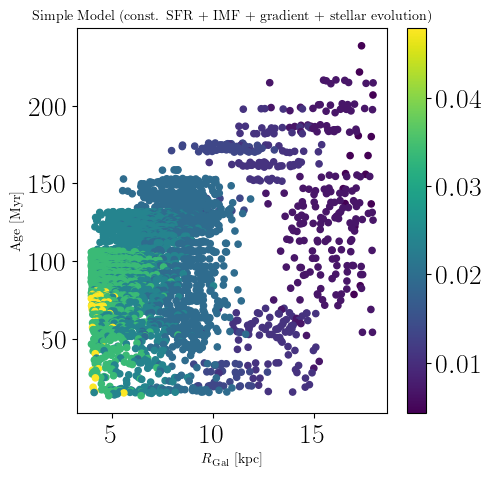

In [15]:
fig = plt.figure(figsize=(5.0, 5.0))
ax  = plt.subplot(111)

ec   = None
#Concatenate the different arrays derived by the metallicity cut and associate it to a new array
cepheids_total_R=np.concatenate((assoc_models["R"][Zcut1][cephcut1],
                                 assoc_models["R"][Zcut2][cephcut2],
                                 assoc_models["R"][Zcut3][cephcut3]))
cepheids_total_age=np.concatenate((assoc_models["age_sim"][Zcut1][cephcut1],
                                   assoc_models["age_sim"][Zcut2][cephcut2],
                                   assoc_models["age_sim"][Zcut3][cephcut3]))
cepheids_total_Z=np.concatenate((assoc_models["Z"][Zcut1][cephcut1],
                                 assoc_models["Z"][Zcut2][cephcut2],
                                 assoc_models["Z"][Zcut3][cephcut3]))
cepheids_total_Teff=np.concatenate((assoc_models['logteff'][Zcut1][cephcut1],
                                    assoc_models['logteff'][Zcut2][cephcut2],
                                    assoc_models['logteff'][Zcut3][cephcut3]))
cepheids_total_logl=np.concatenate((assoc_models['logl'][Zcut1][cephcut1],
                                    assoc_models['logl'][Zcut2][cephcut2], 
                                    assoc_models['logl'][Zcut3][cephcut3]))

# PLOT weightened by Z
plt.scatter(cepheids_total_R, cepheids_total_age, c=cepheids_total_Z, s=20, marker="o",
            edgecolor=ec, cmap="viridis") 

# Beautify  the plot
ax.set_xlabel(r"$R_{\rm Gal}$  [kpc]", fontsize=10)
ax.set_ylabel(r"Age    [Myr]", fontsize=10)
plt.colorbar()
plt.title("Simple Model (const. SFR + IMF + gradient + stellar evolution)", fontsize=10)
#plt.savefig("R_age_simplemodel_w_Z.png", dpi=200)
plt.show()

Age(Z) for Cepheids (not important)

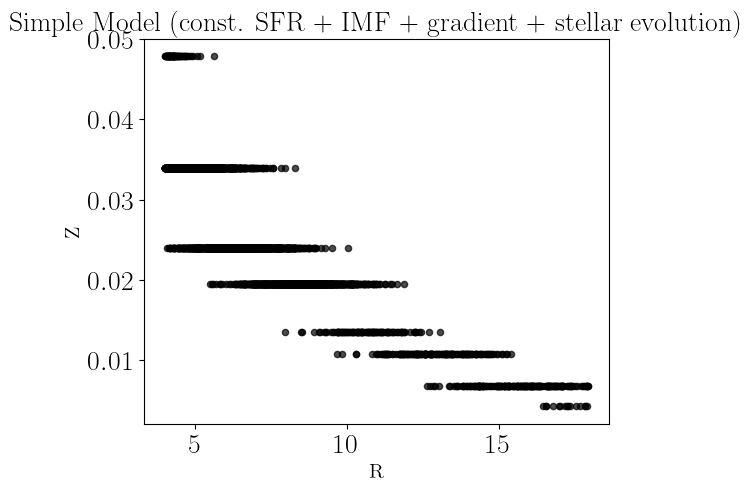

In [16]:
fig = plt.figure(figsize=(6.0, 5.0))
ax  = plt.subplot(111)

ec   = None

# PLOT age(Z)
plt.scatter(cepheids_total_R, cepheids_total_Z, s=20, c="k", marker="o",
            edgecolor=ec, alpha=0.7) 


ax.set_xlabel(r"R", fontsize=15)
ax.set_ylabel(r"Z", fontsize=15)

plt.title("Simple Model (const. SFR + IMF + gradient + stellar evolution)", fontsize=20)

#plt.savefig("fe_age_simplemodel.png", dpi=200)
plt.show()

## IS interpolation 

In [17]:
def interpolate(Z):
    """From a metallicity (Z) input it returns the 2 values for the instability
    strip limits (Somma2021)"""
    fbea=6.1633*Z+3.7927
    fbeb=-2.1429*Z-0.005
    frea=1.8114*Z+3.9552
    freb=-0.7908*Z-0.0726
    return fbea, fbeb, frea, freb
print(max(assoc_models["m_h"]), min(assoc_models["m_h"]))

0.45 -0.6


In [18]:
def interpolate(m_h):
#Regressio feta a Program Lab general (fora de les carpetes de cada pràctica)
    """From a metallicity input it returns the 2 values for the instability
    strip limits (Somma2021)"""
    fbea=0.1863*m_h+3.926 #r=0.956
    fbeb=-0.0651*m_h-0.0502 #r=0.961
    frea=0.0584*m_h+3.9940 #r=0.99993
    freb=-0.0253*m_h-0.0894 #r=0.9996
    return fbea, fbeb, frea, freb

In [19]:
#Create a new dictionary for cepheids in the instability strip defined by the interpolation
cepheids_int={}
cepheids_int["logteff"]=np.zeros(len(assoc_models["logteff"]))
cepheids_int["logl"]=np.zeros(len(assoc_models["logteff"]))
cepheids_int["Z"]=np.zeros(len(assoc_models["logteff"]))
cepheids_int["m_h"]=np.zeros(len(assoc_models["m_h"]))
cepheids_int["logage"]=np.zeros(len(assoc_models["logage"]))
#assoc_models["R"]=stars_alive["R"]
cepheids_int["R"]=np.zeros(len(assoc_models["R"]))

#Associate the model to this new dic if it is inside the instability strip
for i in range(0, len(assoc_models["logteff"])):
    #Must satisfy: inside IS RE and BE and coherent metallicity, and luminosity cut
    if assoc_models["logteff"][i] < (interpolate(assoc_models["m_h"][i])[0]+assoc_models["logl"][i]*interpolate(assoc_models["m_h"][i])[1]):
        if assoc_models["logteff"][i] > (interpolate(assoc_models["m_h"][i])[2]+assoc_models["logl"][i]*interpolate(assoc_models["m_h"][i])[3]):
            if assoc_models["logl"][i]>2.5:
                cepheids_int["logteff"][i]=assoc_models["logteff"][i]   
                cepheids_int["logl"][i]=assoc_models["logl"][i]
                cepheids_int["m_h"][i]=assoc_models["m_h"][i]
                cepheids_int["logage"][i]=assoc_models["logage"][i]
                cepheids_int["R"][i]=assoc_models["R"][i]             

In [20]:
def select_cepheids(models):
    #Create a new dictionary for cepheids in the instability strip defined by the interpolation
    ceph_int={}
    ceph_int["logteff"]=np.zeros(len(models["logteff"]))
    ceph_int["logl"]=np.zeros(len(models["logteff"]))
    ceph_int["Z"]=np.zeros(len(models["logteff"]))
    ceph_int["m_h"]=np.zeros(len(models["m_h"]))
    ceph_int["logage"]=np.zeros(len(models["logage"]))
    #assoc_models["R"]=stars_alive["R"]
    ceph_int["R"]=np.zeros(len(models["R"]))
    
    #Associate the model to this new dic if it is inside the instability strip
    for i in range(0, len(models["logteff"])):
        #Must satisfy: inside IS RE and BE and coherent metallicity, and luminosity cut
        if models["logteff"][i] < (interpolate(models["m_h"][i])[0]+models["logl"][i]*interpolate(models["m_h"][i])[1]):
            if models["logteff"][i] > (interpolate(models["m_h"][i])[2]+models["logl"][i]*interpolate(models["m_h"][i])[3]):
                if models["logl"][i]>2.5:
                    ceph_int["logteff"][i]=models["logteff"][i]   
                    ceph_int["logl"][i]=models["logl"][i]
                    ceph_int["m_h"][i]=models["m_h"][i]
                    ceph_int["logage"][i]=models["logage"][i]
                    ceph_int["R"][i]=models["R"][i]
    return ceph_int

In [21]:
cepheids_int = select_cepheids(assoc_models)
cepheids_int_sinRgrad = select_cepheids(assoc_models_sinRgrad)

### HRD interpolation

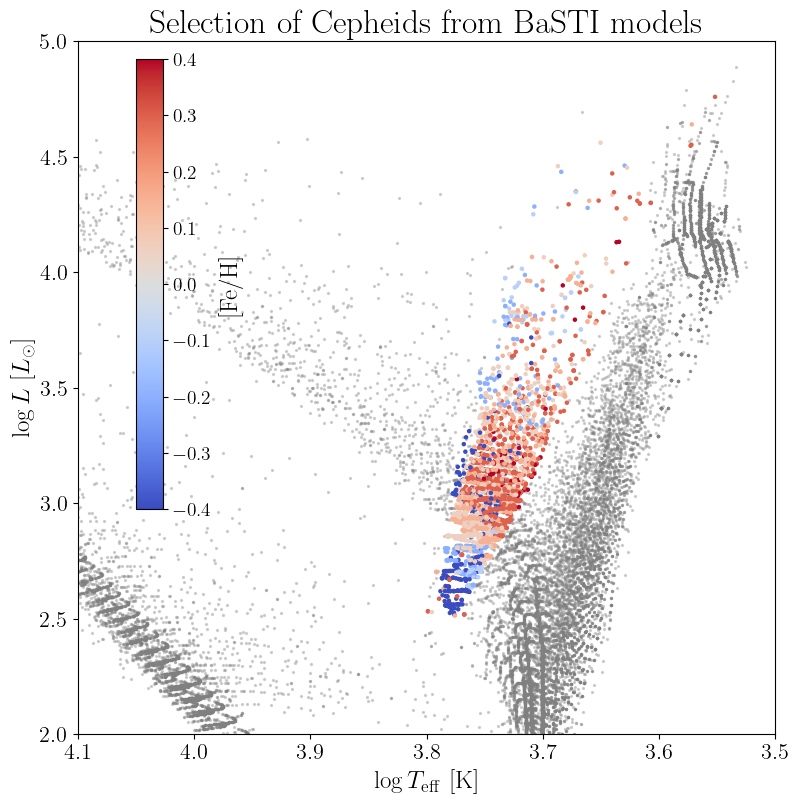

In [22]:
### try to shuffle lines? 
cepheids_int_rdm = pd.DataFrame(cepheids_int).sample(frac=1)
fig, ax = plt.subplots(1, 1, figsize=(9.0, 9.0))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ec=None
ax.scatter(assoc_models["logteff"][::10], assoc_models["logl"][::10], c="grey", s=2, alpha=0.3)
ax.scatter(cepheids_int_rdm["logteff"], cepheids_int_rdm["logl"], c=cepheids_int_rdm["m_h"],s=20, marker=".", 
#plt.scatter(test["logteff"], test["logl"], c=test["m_h"],s=10, marker="o",
            edgecolor=ec, cmap="coolwarm", vmin=-0.4, vmax=0.4) 
#plt.axis([4.3,3.4,2.1,5])
#plt.axis([3.82,3.55,2.4,4.8])
ax.axis([4.1,3.5,2.0,5])
ax.set_xlabel(r"$\log T_{\rm eff}$ [K]", fontsize=18)
ax.set_ylabel(r"$\log L$ [$L_{\odot}$]", fontsize=18)

plt.title("Selection of Cepheids from BaSTI models")

#cax = fig.add_axes([0.81, 0.46, 0.02, 0.4]) # meaning: ([left, bottom, width, height])
cax = fig.add_axes([0.19, 0.36, 0.03, 0.5])
norm = matplotlib.colors.Normalize(vmin=-0.4, vmax=0.4)
cb = matplotlib.colorbar.ColorbarBase(cax, norm=norm, cmap="coolwarm") #, cmap="inferno", norm=norm, spacing='proportional'
cb.set_label('[Fe/H]', fontsize=18)
cb.ax.tick_params(labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('./im/HR_Z_metdepIS_basti.png', dpi=200)
plt.show()

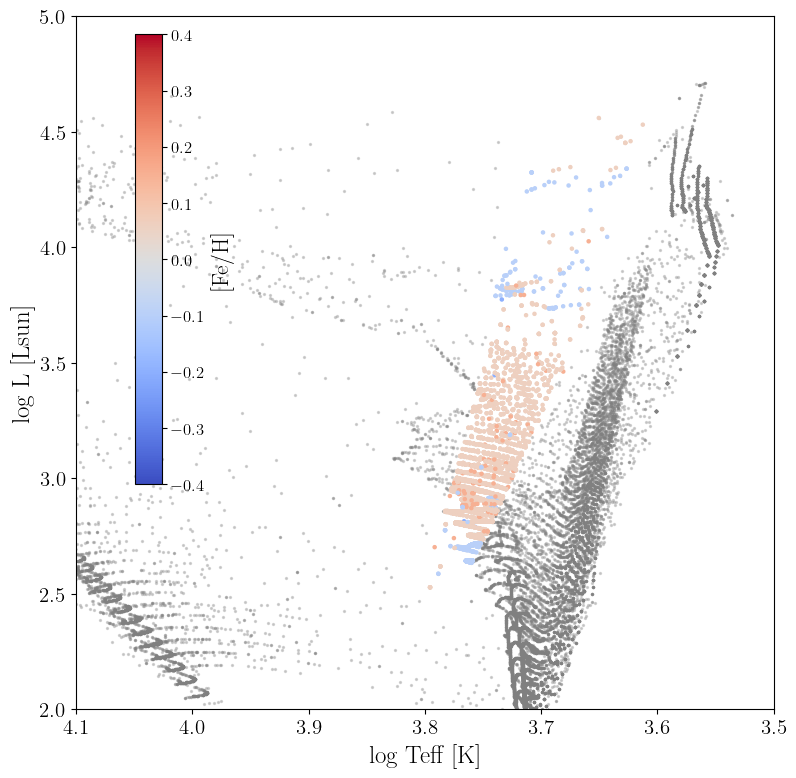

In [23]:
### same but with no R metallicity gradient
fig, ax = plt.subplots(1, 1, figsize=(9.0, 9.0))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ec=None
ax.scatter(assoc_models_sinRgrad["logteff"][::10], assoc_models_sinRgrad["logl"][::10], c="grey", s=2, alpha=0.3)
ax.scatter(cepheids_int_sinRgrad["logteff"], cepheids_int_sinRgrad["logl"], c=cepheids_int_sinRgrad["m_h"],s=20, marker=".", 
#plt.scatter(test["logteff"], test["logl"], c=test["m_h"],s=10, marker="o",
            edgecolor=ec, cmap="coolwarm", vmin=-0.4, vmax=0.4) 
#plt.axis([4.3,3.4,2.1,5])
#plt.axis([3.82,3.55,2.4,4.8])
ax.axis([4.1,3.5,2.0,5])
ax.set_xlabel(r"log Teff [K]", fontsize=18)
ax.set_ylabel(r"log L [Lsun]", fontsize=18)

#cax = fig.add_axes([0.81, 0.46, 0.02, 0.4]) # meaning: ([left, bottom, width, height])
cax = fig.add_axes([0.19, 0.36, 0.03, 0.5])
norm = matplotlib.colors.Normalize(vmin=-0.4, vmax=0.4)
cb = matplotlib.colorbar.ColorbarBase(cax, norm=norm, cmap="coolwarm") #, cmap="inferno", norm=norm, spacing='proportional'
cb.set_label('[Fe/H]', fontsize=17)
cb.ax.tick_params(labelsize=12)
ax.tick_params(axis='both', which='major', labelsize=15)

#plt.savefig('HR_Z_Somma2016.png', dpi=200)
plt.show()

Radial-age dependende of Cepheids with the interpolation on the IS edges defined:


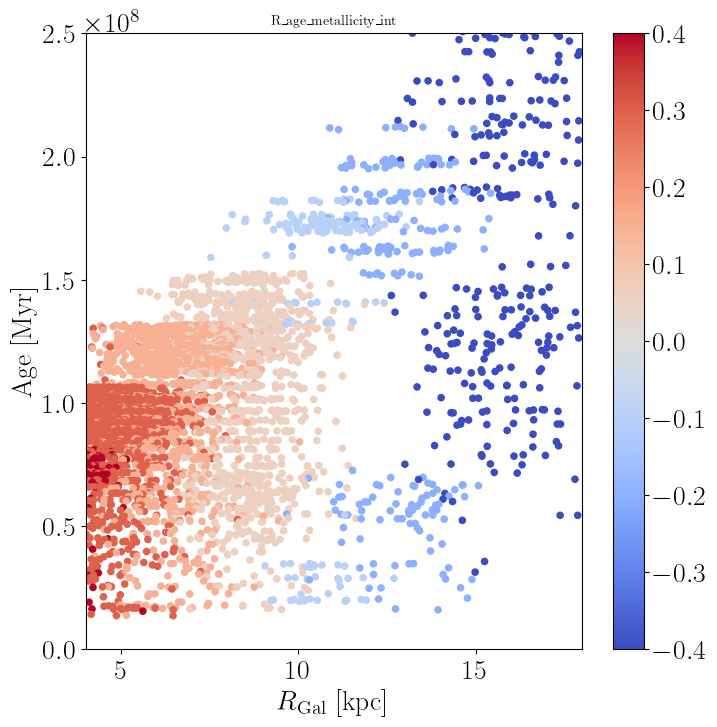

In [24]:
fig = plt.figure(figsize=(8.0, 8.0))
ax  = plt.subplot(111)

ec   = None
# PLOT weightened by Z
plt.scatter(cepheids_int['R'], 10**cepheids_int['logage'], c=cepheids_int['m_h'], s=20, marker="o",
            edgecolor=ec, cmap="coolwarm", vmin=-0.4, vmax=0.4) 

# Beautify  the plot
ax.set_xlabel(r"$R_{\rm Gal}$  [kpc]")
ax.set_ylabel(r"Age    [Myr]")
plt.colorbar()
plt.axis([4., 18.,0., 2.5*1e8])
plt.title("R_age_metallicity_int", fontsize=10)
#plt.savefig("R_age_metallicity_int.png", dpi=200)
plt.show()

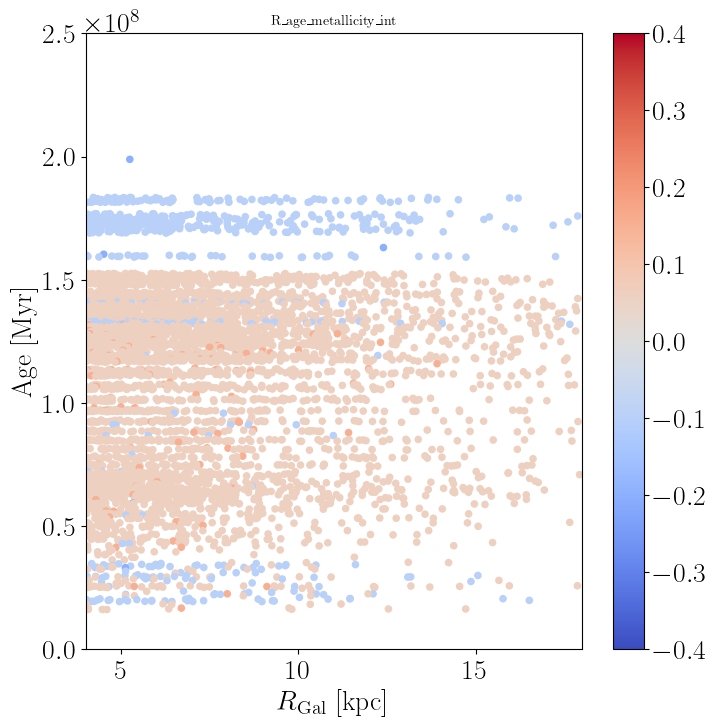

In [25]:
### Z dependent IS + NO R grad

fig = plt.figure(figsize=(8.0, 8.0))
ax  = plt.subplot(111)

ec   = None
# PLOT weightened by Z
plt.scatter(cepheids_int_sinRgrad['R'], 10**cepheids_int_sinRgrad['logage'], c=cepheids_int_sinRgrad['m_h'], s=20, marker="o",
            edgecolor=ec, cmap="coolwarm", vmin=-0.4, vmax=0.4) 

# Beautify  the plot
ax.set_xlabel(r"$R_{\rm Gal}$  [kpc]")
ax.set_ylabel(r"Age    [Myr]")
plt.colorbar()
plt.axis([4., 18.,0., 2.5*1e8])
plt.title("R_age_metallicity_int", fontsize=10)
#plt.savefig("R_age_metallicity_int.png", dpi=200)
plt.show()

Number of stars inside the IS given by the interpollation

### Histograms

NameError: name 'stars_alive' is not defined

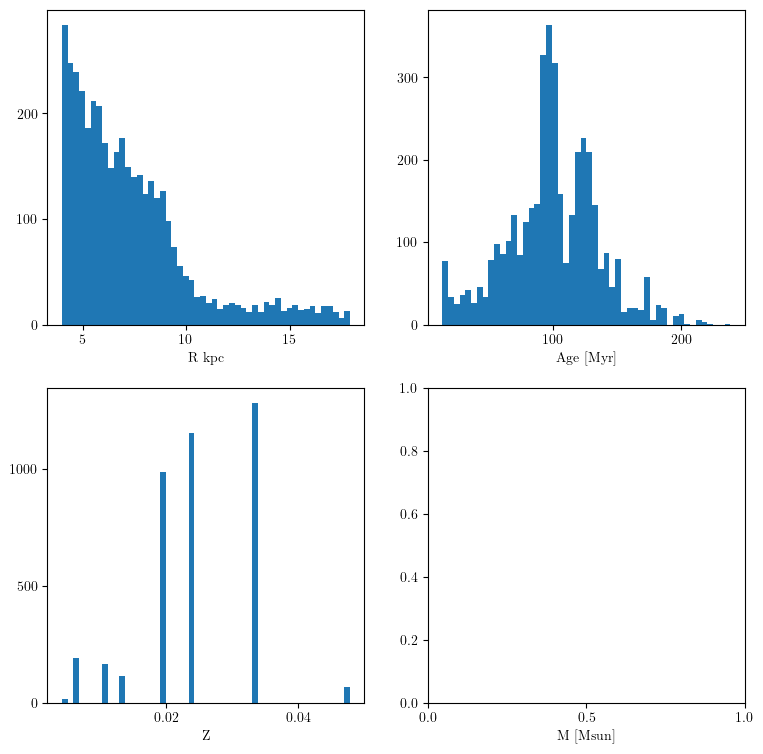

In [26]:
fig = plt.figure(figsize=(9, 9))
#Set the number of bins
b=50
ax  = plt.subplot(221)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.set_xlabel(r" R kpc", fontsize=10)
plt.hist(cepheids_total_R, bins =b)
ax  = plt.subplot(222)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.set_xlabel(r" Age [Myr]", fontsize=10)
plt.hist(cepheids_total_age, bins =b)
ax  = plt.subplot(223)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.set_xlabel(r" Z", fontsize=10)
plt.hist(cepheids_total_Z, bins =b)
ax  = plt.subplot(224)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.set_xlabel(r" M [Msun]", fontsize=10)
plt.hist(stars_alive['M'], bins =b)
plt.show()

# Fig.4 in the paper
- observational data
- best simulation
- cst IS + metallicity gradient w/ Rgal
- IS % \[FE/H\] + NO metallicity gradient

In [27]:
### import observational data for the summary plot
pietru = Table.read("./data/FCC_sample_April2024.fits")
vmin = 0
vmax = 300
cut_p  = pietru["ageMyr"]<vmax

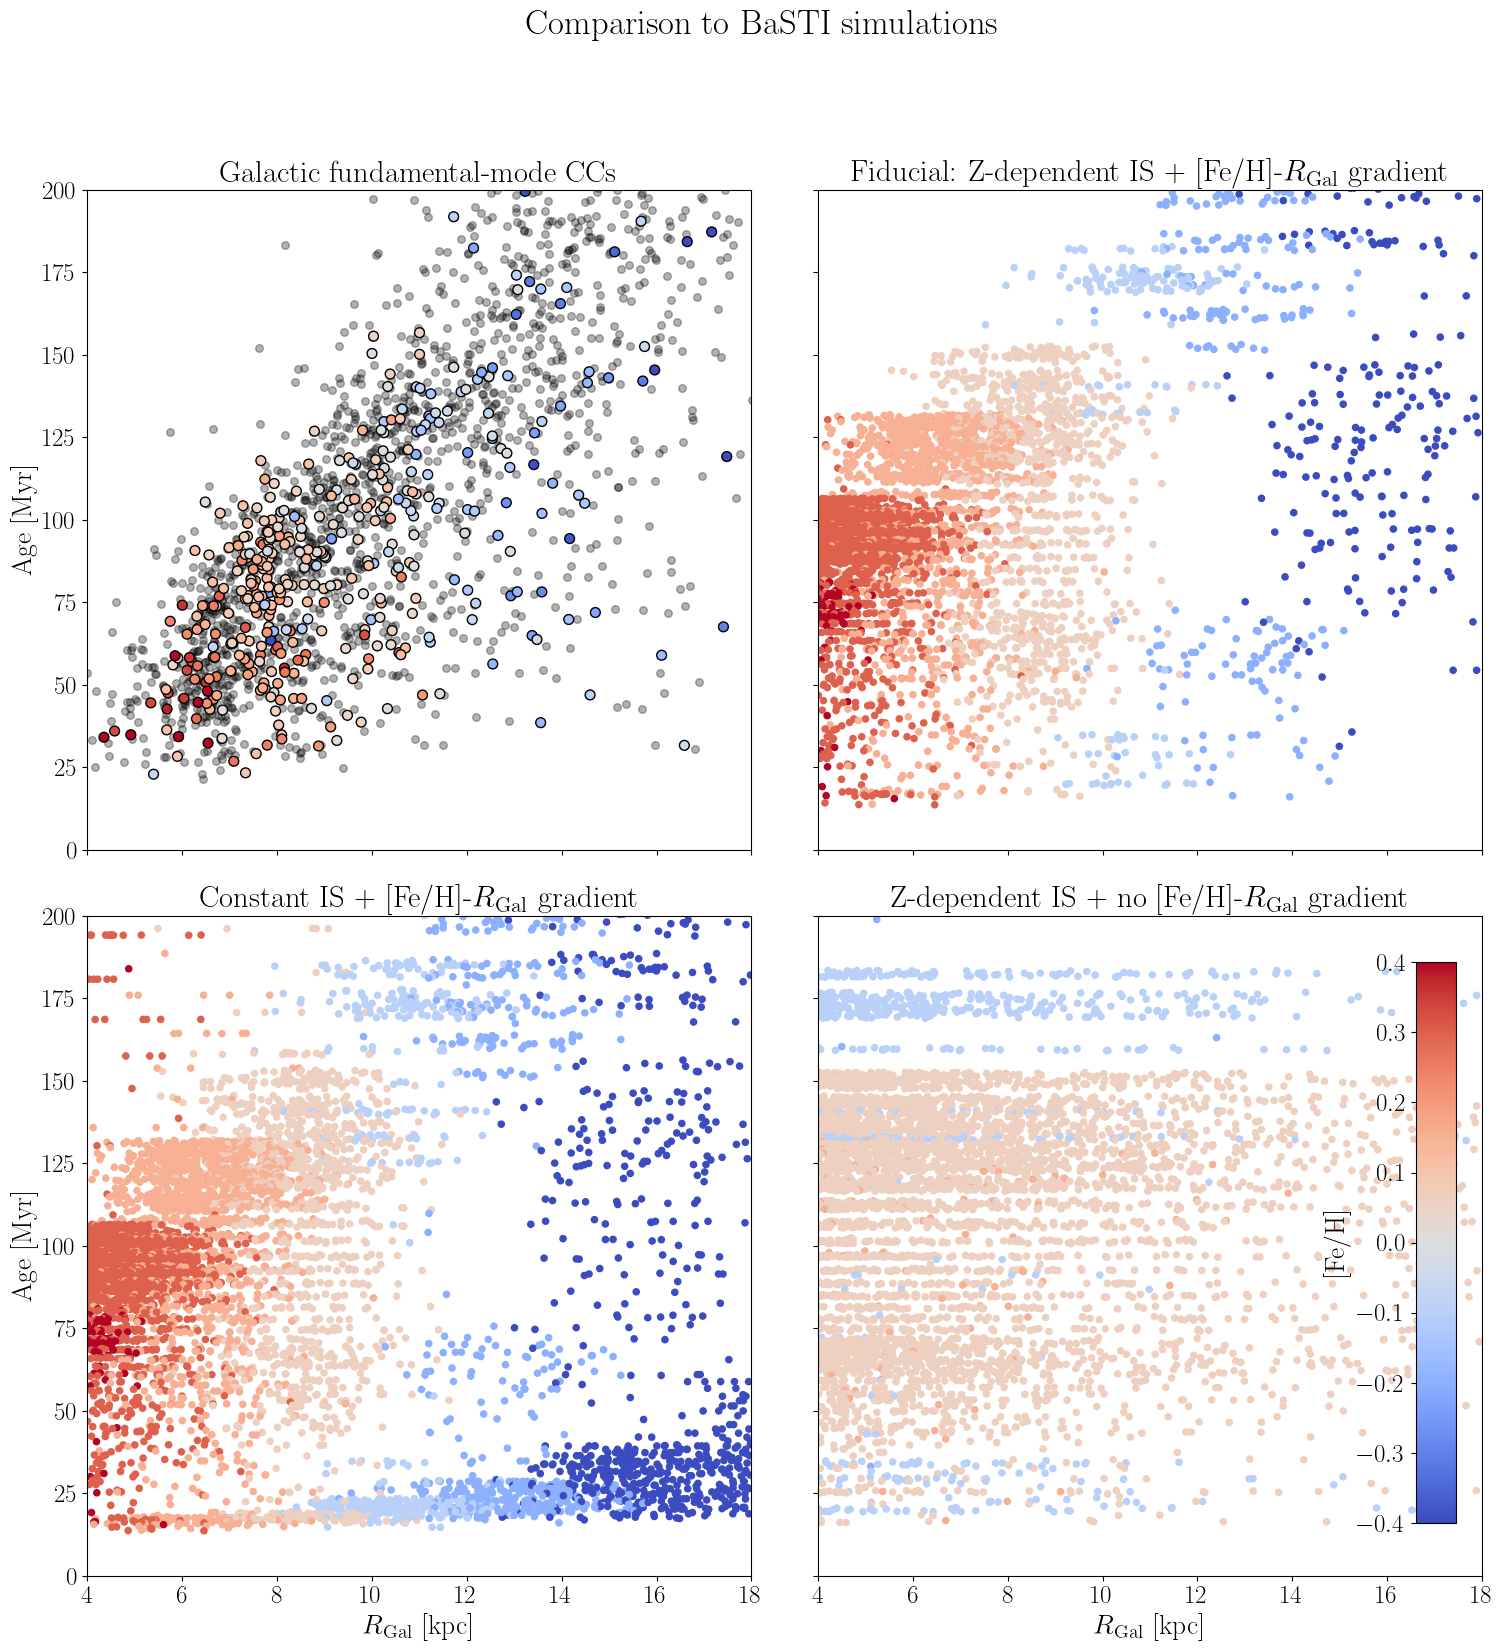

In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18.0, 18.0), sharex=True, sharey=True)
                               #gridspec_kw={'width_ratios': [0.8, 1]})
fig.subplots_adjust(wspace=0.1, hspace=0.1)
ec   = None
fs=20

##### observational data
ax1.scatter(np.sqrt(pietru["X"][cut_p]**2. + pietru["Y"][cut_p]**2.), pietru["ageMyr"][cut_p],
            s=30, c="k", marker="o", alpha=0.3)

# Overplot Cepheids with known metallicities in colour
spec = np.isfinite(pietru["__Fe_H_"])
ax1.scatter(np.sqrt(pietru["X"][cut_p & spec]**2. + pietru["Y"][cut_p & spec]**2.), 
            pietru["ageMyr"][cut_p & spec], s=50, c=pietru["__Fe_H_"][cut_p & spec], 
            marker="o", edgecolor="k", vmin=-.4, vmax=0.4, cmap="coolwarm")

### colorbar
x4 = ax4.get_position().xmax - ax4.get_position().xmin
y4 = ax4.get_position().ymax - ax4.get_position().ymin
cax1 = fig.add_axes([ax4.get_position().xmax-0.1*x4, ax4.get_position().ymin+0.08*y4, 0.06*x4, 0.85*y4]) # meaning: ([left, bottom, width, height])
#cax1 = fig.add_axes(np.array([0.42, 0.5, 0.02, 0.35]))
norm1 = matplotlib.colors.Normalize(vmin=-0.4, vmax=0.4)
cb1 = matplotlib.colorbar.ColorbarBase(cax1, norm=norm1, cmap="coolwarm") #, cmap="inferno", norm=norm, spacing='proportional'
cb1.set_label('[Fe/H]', fontsize=fs)
cax1.yaxis.set_ticks_position('left')
cax1.yaxis.set_label_position('left')
cax1.tick_params(labelsize=fs-2)

#cax1 = fig.add_axes([0.15, 0.52, 0.02, 0.4])
#norm = matplotlib.colors.Normalize(vmin=-0.4, vmax=0.4)
#cb = matplotlib.colorbar.ColorbarBase(cax, norm=norm, cmap="coolwarm") #, cmap="inferno", norm=norm, spacing='proportional'
#cb.set_label('[Fe/H]')

##### best simu
ax2.scatter(cepheids_int['R'], 10**cepheids_int['logage']/1e6, c=cepheids_int['m_h'], s=20, marker="o",
            edgecolor=ec, cmap="coolwarm", vmin=-0.4, vmax=0.4) 


##### constant IS + [Fe/H] gradient w/ Rgal
c3 = ax3.scatter(assoc_models["R"][cephcut], (10**assoc_models["logage"][cephcut]/1e6), c=assoc_models["m_h"][cephcut],
            s=20, marker="o", edgecolor=ec, vmin=-0.4, vmax=0.4, cmap="coolwarm") 

#### Z dependent IS + NO [Fe/H] gradient w/ R
ax4.scatter(cepheids_int_sinRgrad['R'], 10**cepheids_int_sinRgrad['logage']/1e6, c=cepheids_int_sinRgrad['m_h'], s=20, marker="o",
            edgecolor=ec, cmap="coolwarm", vmin=-0.4, vmax=0.4) 


### Use age from is or simu????????
#ax2.scatter(assoc_models["R"][cephcut], assoc_models["age_sim"][cephcut], c=assoc_models["m_h"][cephcut],
#            s=20, marker="o", edgecolor=ec, vmin=-0.4, vmax=0.4, cmap="coolwarm") 

# Beautify the plot
ax1.tick_params(axis='both', which='major', labelsize=fs-2)
ax2.tick_params(axis='both', which='major', labelsize=fs-2)
ax3.tick_params(axis='both', which='major', labelsize=fs-2)
ax4.tick_params(axis='both', which='major', labelsize=fs-2)

ax1.set_ylabel(r"Age [Myr]", fontsize=fs)
ax1.set_title("Galactic fundamental-mode CCs", fontsize=fs+2)

ax3.set_xlabel(r"$R_{\rm Gal}$  [kpc]", fontsize=fs)
ax3.set_ylabel(r"Age    [Myr]", fontsize=fs)

ax3.set_xlim(4, 18)
ax3.set_ylim(0, 200)

ax4.set_xlabel(r"$R_{\rm Gal}$  [kpc]", fontsize=fs)

ax2.set_title(r"Fiducial: Z-dependent IS + [Fe/H]-$R_{\rm Gal}$ gradient", fontsize=fs+2)
ax3.set_title(r"Constant IS + [Fe/H]-$R_{\rm Gal}$ gradient", fontsize=fs+2)
ax4.set_title(r"Z-dependent IS + no [Fe/H]-$R_{\rm Gal}$ gradient", fontsize=fs+2)
plt.suptitle(r"Comparison to BaSTI simulations", fontsize=fs+5)
plt.savefig("./im/radial_age_gradient_4panels.png", format='png')
plt.show()